# PyTorch Faster R-CNN on Citypersons dataset

This is a basic pipeline for pedestrian detection using Faster R-CNN with resnet50 backbone, pretrained on COCO dataset, using PyTorch by following this tutorial [https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html]. 

Currently trained the heads using only 234 images from Hamburg (from Cityscapes dataset) and annotations (ground truths) from Citypersons dataset. Split: 50 images for test set and $234 - 50$ images for train set.

TODO:
1. Train on complete train set (whole `anno_train.mat`). 
2. Evaluate on the test set (`anno_val.mat`).
    1. Prepare detection results in COCO format, and write them in a single .json file.
    2. Run eval_demo.py from Citypersons GitHub; see [https://github.com/cvgroup-njust/CityPersons/tree/master/evaluation/eval_script/?at=default].
    3. Detailed evaluations will be written to results.txt.

## Setup

### Dependencies

Tested using torch.__version__ = 1.8.0. To install other dependencies run:

```bash
$ pip install --upgrade pip
$ pip install torchvision
$ pip install cython
$ pip install pycocotools
$ pip install torch-summary
```

### Helper functions

We will import some helper functions to simplify training and evaluating detection model. We will use `/references/detection/{engine, utils, transforms}.py` from `pytorch.vision` repository:

```bash
$ git clone https://github.com/pytorch/vision.git
$ mkdir pytorch-helpers
$ cd vision
$ git checkout v0.3.0
$ cp references/detection/utils.py ../pytorch-helpers/
$ cp references/detection/transforms.py ../pytorch-helpers/
$ cp references/detection/coco_eval.py ../pytorch-helpers/
$ cp references/detection/engine.py ../pytorch-helpers/
$ cp references/detection/coco_utils.py ../pytorch-helpers/
$ cd ../pytorch-helpers/
$ chmod +x *
```

### Imports

In [1]:
import scipy.io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchsummary import summary

In [2]:
%cd C:\Users\Student\PyTorchProjekte\pedestrian-detection\src\pytorch-helpers

C:\Users\Student\PyTorchProjekte\pedestrian-detection\src\pytorch-helpers


In [3]:
# from ./src/pytorch-helpers
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [4]:
%cd C:\Users\Student\PyTorchProjekte

C:\Users\Student\PyTorchProjekte


## Data

To get the data first download the images from our data server. Let's download only Hamburg images to hamburg directory:
```bash
$ mkdir hamburg # from project's root directory
$ cd hamburg
$ scp user1@159.89.9.230:/home/user1/cityscapes-dataset/leftImg8bit/train/hamburg/* .
$ cd ..
```

To get annotations from Citypersons dataset, clone their GitHub repository:
```bash
$ git clone https://github.com/cvgroup-njust/CityPersons.git
```

Let's save the image path and annotations path:

In [5]:
img_path = './datasets/hamburg/'
anno_path = './datasets/CityPersons/annotations/'

In [6]:
def get_annotations(anno_path):
    ''' Prepares data - only train data for now, by
    transforming annotations from .mat format to a dictionary.
    '''
    
    anno_train = scipy.io.loadmat(anno_path + 'anno_train.mat')
    anno_train = anno_train['anno_train_aligned']

    d = {}
    for i in range(anno_train[0].shape[0]):
        # extract data from the annotations matrix
        city_name = anno_train[0, i][0][0][0][0]
        img_name = anno_train[0, i][0][0][1][0]

        bboxes = []
        for bb in anno_train[0, i][0][0][2]:
            ## format is: [class_label, x1,y1,w,h, instance_id, x1_vis, y1_vis, w_vis, h_vis]
            if bb[0] == 1: # class_label = 1 means it is a pedestrian
                bboxes.append(bb[1:5]) # bbox = [x, y, w, h]

        if city_name == 'hamburg':
            d[img_name] = bboxes
    
    return d

In [7]:
anno_dict = get_annotations(anno_path)
print('There are %d examples from Hamburg' % len(anno_dict))
print('\nFirst example: ')

There are 248 examples from Hamburg

First example: 


In [8]:
img_name = list(anno_dict.keys())[0]
print(img_name)
print('\nAnnotations: ')
anno_dict[img_name]

hamburg_000000_000042_leftImg8bit.png

Annotations: 


[array([682, 401,  13,  33], dtype=uint16),
 array([202, 418,  20,  50], dtype=uint16),
 array([166, 403,  30,  71], dtype=uint16),
 array([1343,  369,    6,   15], dtype=uint16),
 array([1637,  352,   30,   73], dtype=uint16),
 array([1826,  308,   62,  150], dtype=uint16),
 array([1867,  291,   69,  168], dtype=uint16),
 array([1469,  352,   31,   76], dtype=uint16)]

In [9]:
imgs = list(sorted(os.listdir(img_path)))
imgs[:10]

['hamburg_000000_000042_leftImg8bit.png',
 'hamburg_000000_002338_leftImg8bit.png',
 'hamburg_000000_003488_leftImg8bit.png',
 'hamburg_000000_003904_leftImg8bit.png',
 'hamburg_000000_004985_leftImg8bit.png',
 'hamburg_000000_005639_leftImg8bit.png',
 'hamburg_000000_006322_leftImg8bit.png',
 'hamburg_000000_007737_leftImg8bit.png',
 'hamburg_000000_008494_leftImg8bit.png',
 'hamburg_000000_013577_leftImg8bit.png']

In [10]:
def show(img_path, img_name, anno_dict):
    '''Shows the image and corresponding annotations.'''
    
    img = Image.open(img_path + img_name)
    bboxes = anno_dict[img_name]

    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()
    ax.imshow(img);

    # bbox = [x, y, w, h]
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)

    plt.title(img_name)
    plt.show()

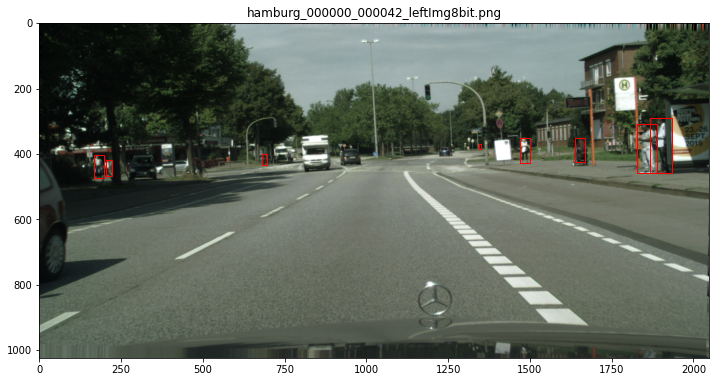

In [11]:
# let's check the first image
show(img_path, imgs[0], anno_dict)

Keep only images with pedestrians

In [12]:
for img in imgs:
    if anno_dict[img] == []:
        os.remove(img_path + img)

In [13]:
imgs = list(sorted(os.listdir(img_path)))
len(imgs)

234

## Prepare Torch.utils.data.Dataset class for this dataset

In [14]:
class HamburgDataset(torch.utils.data.Dataset):
    def __init__(self, root, anno_dict, transforms=None):
        '''
        root: img_path (e.g. hamburg directory of images)
        anno_dict: 
        '''
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(root)))
        self.anno = anno_dict
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        ## prepare bboxes coordinates 
        # transform from [x, y, w, h] to [x0, y0, x1, y1]
        boxes = []
        for bbox in self.anno[self.imgs[idx]]:
            x, y = bbox[0], bbox[1]
            w, h = bbox[2], bbox[3]
            boxes.append([x, y, x+w, y+h])
        
        # transform to torch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        ## define labels, there is only one class
        num_objs = len(boxes)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        ## other definitions
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd        
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target        
        
    def __len__(self):
        return len(self.imgs)

In [15]:
#img_path = './hamburg/'
#anno_path = './CityPersons/annotations/'

anno_dict = get_annotations(anno_path)
dataset = HamburgDataset(img_path, anno_dict)

In [16]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=2048x1024 at 0x2301DFBF4F0>,
 {'boxes': tensor([[ 682.,  401.,  695.,  434.],
          [ 202.,  418.,  222.,  468.],
          [ 166.,  403.,  196.,  474.],
          [1343.,  369., 1349.,  384.],
          [1637.,  352., 1667.,  425.],
          [1826.,  308., 1888.,  458.],
          [1867.,  291., 1936.,  459.],
          [1469.,  352., 1500.,  428.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'image_id': tensor([0]),
  'area': tensor([  429.,  1000.,  2130.,    90.,  2190.,  9300., 11592.,  2356.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0])})

## Define the model

In [17]:
def get_model():
    # load a model pre-trained pre-trained on COCO choose one
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)     
    
    return model

## Train the model

In [18]:
def get_transform(train):
    ''' Converts the image, a PIL image, into a PyTorch Tensor. '''
    
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        
    return T.Compose(transforms)

We do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Faster R-CNN model.

In [19]:
# split dataset into train and test
dataset = HamburgDataset(img_path, anno_dict, get_transform(train=True))
dataset_test = HamburgDataset(img_path, anno_dict, get_transform(train=False))

# first permute the indices
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
len(indices)

234

In [20]:
# train: 248 - 50 examples
# test: 50 examples
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [21]:
# define training and validation data loaders
# For my Windows CPU I have to set the numbers of workers to 0
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [23]:
model = get_model()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [24]:
#List of all layers
#for name, param in model.named_parameters():
#     print(name)

In [25]:
#setting param.requires_grad = False freezes the layer 
for name, param in model.named_parameters():
    if 'backbone.body' in name:
        param.requires_grad = False
            
for name, param in model.named_parameters():
    if 'backbone.fpn' in name:
        param.requires_grad = False
            
for name, param in model.named_parameters():
    if 'rpn' in name:
        param.requires_grad = False
            
for name, param in model.named_parameters():
    if 'roi_heads.box_head' in name:
        param.requires_grad = False
            
for name, param in model.named_parameters():
    if 'roi_heads.box_predictor' in name:
        param.requires_grad = True

In [26]:
summary(model,input_size=(3,2048,1024))

Layer (type:depth-idx)                   Param #
├─GeneralizedRCNNTransform: 1-1          --
├─BackboneWithFPN: 1-2                   --
|    └─IntermediateLayerGetter: 2-1      --
|    |    └─Conv2d: 3-1                  (9,408)
|    |    └─FrozenBatchNorm2d: 3-2       --
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              (212,992)
|    |    └─Sequential: 3-6              (1,212,416)
|    |    └─Sequential: 3-7              (7,077,888)
|    |    └─Sequential: 3-8              (14,942,208)
|    └─FeaturePyramidNetwork: 2-2        --
|    |    └─ModuleList: 3-9              (984,064)
|    |    └─ModuleList: 3-10             (2,360,320)
|    |    └─LastLevelMaxPool: 3-11       --
├─RegionProposalNetwork: 1-3             --
|    └─AnchorGenerator: 2-3              --
|    └─RPNHead: 2-4                      --
|    |    └─Conv2d: 3-12                 (590,080)
|    |    └─Conv2d: 3-13                 (771)
|    

Layer (type:depth-idx)                   Param #
├─GeneralizedRCNNTransform: 1-1          --
├─BackboneWithFPN: 1-2                   --
|    └─IntermediateLayerGetter: 2-1      --
|    |    └─Conv2d: 3-1                  (9,408)
|    |    └─FrozenBatchNorm2d: 3-2       --
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              (212,992)
|    |    └─Sequential: 3-6              (1,212,416)
|    |    └─Sequential: 3-7              (7,077,888)
|    |    └─Sequential: 3-8              (14,942,208)
|    └─FeaturePyramidNetwork: 2-2        --
|    |    └─ModuleList: 3-9              (984,064)
|    |    └─ModuleList: 3-10             (2,360,320)
|    |    └─LastLevelMaxPool: 3-11       --
├─RegionProposalNetwork: 1-3             --
|    └─AnchorGenerator: 2-3              --
|    └─RPNHead: 2-4                      --
|    |    └─Conv2d: 3-12                 (590,080)
|    |    └─Conv2d: 3-13                 (771)
|    

In [27]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [28]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let's train the model for 10 epochs, evaluating at the end of every epoch.

Her start the changes nessasary, to display the losses. I edited the train_one_epoch function to output the losses while training and added test_one_epoch to output the losses in the Test data. The Model is in both cases in the training state, because that is the only way I could get the intrnaly computet losses, at least until now.

In [29]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):    
    
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    
    losses_lists = [] 
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
            
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()
        
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)
        
        help_list = []
        for loss in loss_dict_reduced.values():
            help_list.append(loss.item())
        losses_lists.append(help_list)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        
    return losses_lists

def test_one_epoch(model, data_loader, device):    
    losses_lists = [] 
    
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
            
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        
        help_list = []
        for loss in loss_dict_reduced.values():
            help_list.append(loss.item())
        losses_lists.append(help_list)
    return losses_lists

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        if device.type !='cpu':
            torch.cuda.synchronize() #dos not work if there is no cuda GPU
            
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [30]:
list_loss_classifier_epochmean = []
list_loss_box_reg_epochmean = []
list_loss_objectness_epochmean = []
list_loss_rpn_box_reg_epochmean = []

test_list_loss_classifier_epochmean = []
test_list_loss_box_reg_epochmean = []
test_list_loss_objectness_epochmean = []
test_list_loss_rpn_box_reg_epochmean = []

In [34]:
#num_epochs = 5

for epoch in range(7,15):
    # train for one epoch, printing every 10 iterations
    losses_lists = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

    list_loss_classifier_epochmean.append(np.mean([x[0] for x in losses_lists]))
    list_loss_box_reg_epochmean.append(np.mean([x[1] for x in losses_lists]))
    list_loss_objectness_epochmean.append(np.mean([x[2] for x in losses_lists]))
    list_loss_rpn_box_reg_epochmean.append(np.mean([x[3] for x in losses_lists]))
    
    test_losses_lists = test_one_epoch(model, data_loader_test,device)
    
    test_list_loss_classifier_epochmean.append(np.mean([x[0] for x in test_losses_lists]))
    test_list_loss_box_reg_epochmean.append(np.mean([x[1] for x in test_losses_lists]))
    test_list_loss_objectness_epochmean.append(np.mean([x[2] for x in test_losses_lists]))
    test_list_loss_rpn_box_reg_epochmean.append(np.mean([x[3] for x in test_losses_lists]))
    
    # update the learning rate
    #lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [7]  [ 0/46]  eta: 0:11:04  lr: 0.005000  loss: 1.1054 (1.1054)  loss_classifier: 0.2131 (0.2131)  loss_box_reg: 0.4491 (0.4491)  loss_objectness: 0.1779 (0.1779)  loss_rpn_box_reg: 0.2653 (0.2653)  time: 14.4462  data: 0.5374  max mem: 0
Epoch: [7]  [10/46]  eta: 0:07:44  lr: 0.005000  loss: 0.7238 (0.8634)  loss_classifier: 0.1455 (0.1550)  loss_box_reg: 0.2783 (0.2939)  loss_objectness: 0.1779 (0.1766)  loss_rpn_box_reg: 0.2032 (0.2379)  time: 12.8978  data: 0.5636  max mem: 0
Epoch: [7]  [20/46]  eta: 0:05:42  lr: 0.005000  loss: 0.9091 (0.9672)  loss_classifier: 0.1484 (0.1652)  loss_box_reg: 0.3110 (0.3014)  loss_objectness: 0.1932 (0.2662)  loss_rpn_box_reg: 0.2043 (0.2343)  time: 13.1234  data: 0.5428  max mem: 0
Epoch: [7]  [30/46]  eta: 0:03:32  lr: 0.005000  loss: 0.9431 (0.9465)  loss_classifier: 0.1661 (0.1610)  loss_box_reg: 0.3153 (0.2985)  loss_objectness: 0.1741 (0.2446)  loss_rpn_box_reg: 0.2278 (0.2424)  time: 13.4583  data: 0.5356  max mem: 0
Epoch: [7]  [40/

KeyboardInterrupt: 

loss_classifier


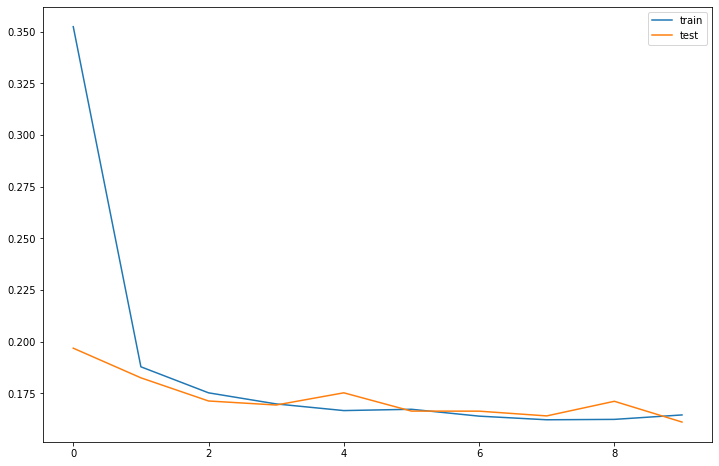

loss_box_reg


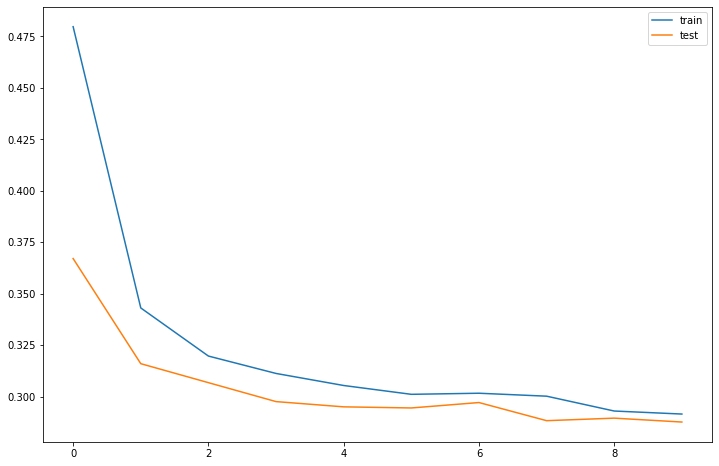

loss_objectness


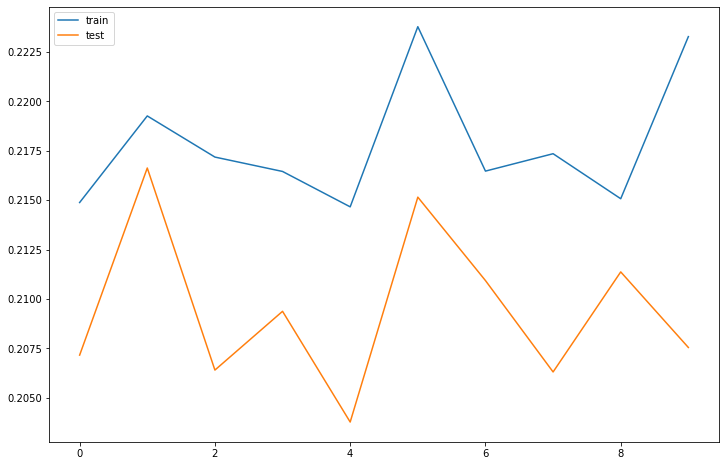

loss_rpn_box_reg


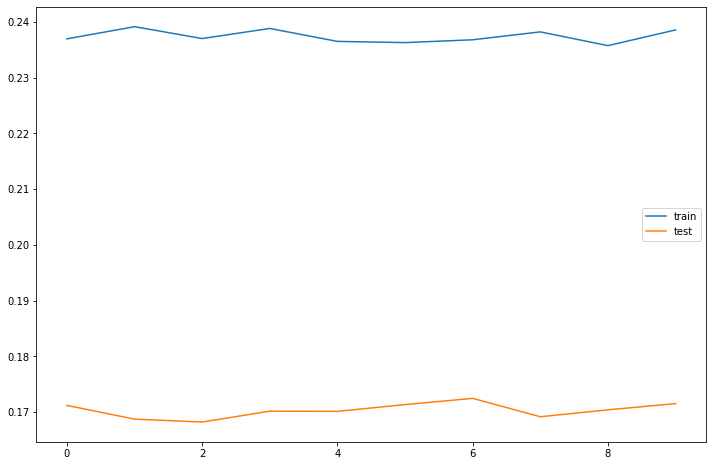

In [35]:
print('loss_classifier')
plt.plot(list_loss_classifier_epochmean, label='train')
plt.plot(test_list_loss_classifier_epochmean, label='test')
plt.legend()
plt.show()

print('loss_box_reg')
plt.plot(list_loss_box_reg_epochmean, label='train')
plt.plot(test_list_loss_box_reg_epochmean, label='test')
plt.legend()
plt.show()

print('loss_objectness')
plt.plot(list_loss_objectness_epochmean, label='train')
plt.plot(test_list_loss_objectness_epochmean, label='test')
plt.legend()
plt.show()

print('loss_rpn_box_reg')
plt.plot(list_loss_rpn_box_reg_epochmean, label='train')
plt.plot(test_list_loss_rpn_box_reg_epochmean, label='test')
plt.legend()
plt.show()

In [33]:
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/50]  eta: 0:05:25  model_time: 6.4014 (6.4014)  evaluator_time: 0.0150 (0.0150)  time: 6.5074  data: 0.0910  max mem: 0
Test:  [49/50]  eta: 0:00:06  model_time: 6.3210 (6.3176)  evaluator_time: 0.0070 (0.0269)  time: 6.4415  data: 0.0906  max mem: 0
Test: Total time: 0:05:21 (6.4365 s / it)
Averaged stats: model_time: 6.3210 (6.3176)  evaluator_time: 0.0070 (0.0269)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.504
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0

***Trained for about half an hour on Nvidia Tesla K-80 GPU with 12GB memory, but only about 32% percent memory usage (3.84GB)!***

## Save or load the model

In [35]:
def save_model(model, path="./models/entire_model.pt"):
    torch.save(model, path)
    print('Model saved to ' + path)
    
def load_model(path="./models/entire_model.pt"):
    if torch.cuda.is_available():
        return torch.load(path)
    else:
        return torch.load(path, map_location=torch.device('cpu'))

In [39]:
torch.save(model,"./models/last1bs8ep15.pt")

## visualyse ground truth and predictions

In the following I combined the code for displaying the ground truths and the predictions for multiple Images.

In [37]:
def convert_back(img, img_raw):
    img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    img = np.array(img)
    print('img shape: %d x %d x %d' % img.shape)
    img = Image.fromarray(np.uint8(img)).convert('RGB')

    img_flipped = np.array(img.transpose(Image.FLIP_LEFT_RIGHT))
    img_raw = np.array(img_raw)
    img_was_flipped = np.sum(img_flipped.flatten() == img_raw.flatten()) == img_flipped.shape[0] * img_flipped.shape[1] * img_flipped.shape[2]
    print('Image was flipped: %r' % img_was_flipped)
    
    return img

img shape: 1024 x 2048 x 3
Image was flipped: False


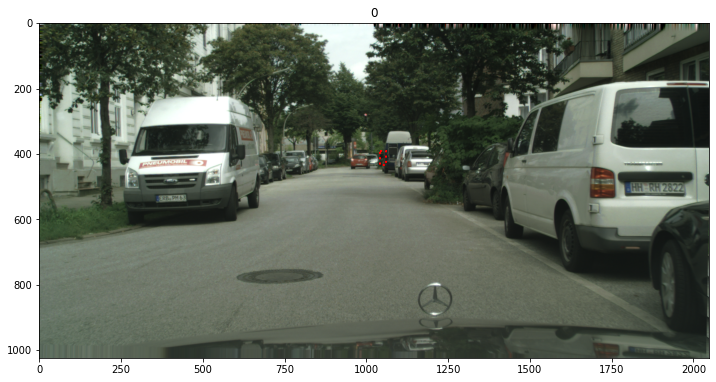

img shape: 1024 x 2048 x 3
Image was flipped: False


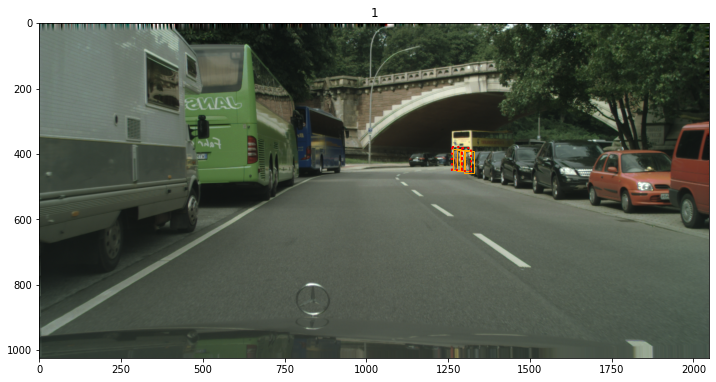

img shape: 1024 x 2048 x 3
Image was flipped: False


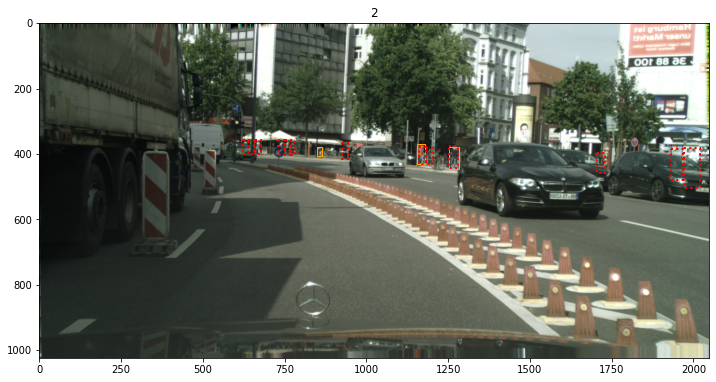

img shape: 1024 x 2048 x 3
Image was flipped: False


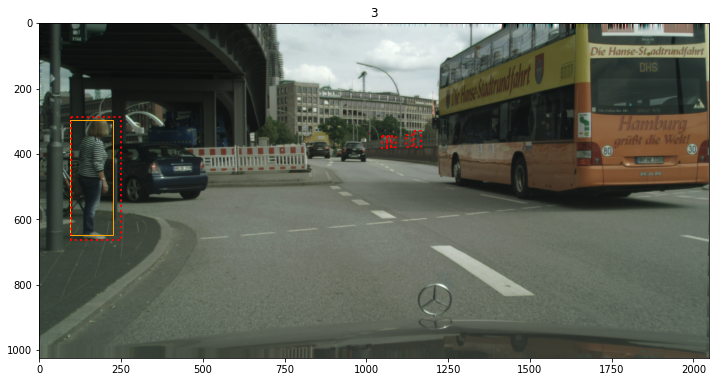

img shape: 1024 x 2048 x 3
Image was flipped: False


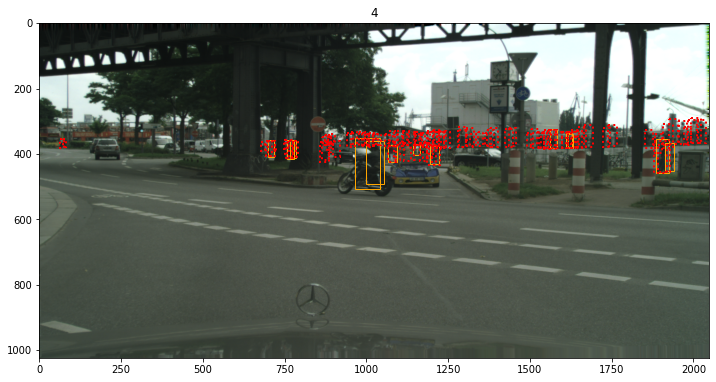

In [38]:
for idx in range(0,5):
    img_raw = Image.open(img_path + imgs[0])
    anno_raw = anno_dict[imgs[0]]
    #idx = indices.index(j)#() ist numer des Bildes 
    img, anno = dataset[idx]
    #img = convert_back(img, img_raw)
    anno = np.array(anno['boxes'])
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
        
    img = convert_back(img, img_raw)
        
    preds = prediction['boxes'] # predicted bboxes
    preds = preds.cpu().data.numpy() # to numpy array
    scores = prediction['scores'] # scores of predicted bboxes
    scores = scores.cpu().data.numpy()
     
    threshold = .5
    highs = list(np.where(scores > threshold)[0])
    bboxes_x0x1y0y1 = []
    
    for high in highs:
        bboxes_x0x1y0y1.append(list(preds[high]))
    
        
    
        
    gt_bboxes = []
    for bbox in anno:
        bbox = list(bbox)
        x0, y0 = bbox[0], bbox[1]
        x1, y1 = bbox[2], bbox[3]
        gt_bboxes.append([x0, y0, x1 - x0, y1 - y0])
        # transform back to [x, y, w, h] format
    
    bboxes = []
    for bbox in bboxes_x0x1y0y1:
        bbox = list(bbox)
        x0, y0 = bbox[0], bbox[1]
        x1, y1 = bbox[2], bbox[3]

        bboxes.append([x0, y0, x1 - x0, y1 - y0])
        
    plt.rcParams['figure.figsize'] = [12, 8]

    fig, ax = plt.subplots()

    ax.imshow(img);
    
    # bbox = [x, y, w, h]
    for bbox in bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=1, edgecolor='orange',linestyle ='-', facecolor='none')
        ax.add_patch(rect)   
    
    #ground truth boxes
    for bbox in gt_bboxes:
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3], 
            linewidth=2, edgecolor='red',linestyle =':', facecolor='none')
        ax.add_patch(rect)
    
    
    plt.title(idx)
    plt.show()